In [46]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from scipy.signal import argrelextrema
import os

import sys
sys.path.append('../../')
from cad.calc.geo import Geo
from cad.calc.conv import freq_to_note_and_cent, note_name
import pandas as pd
import seaborn as sns
from sklearn import svm

import json

def do_fft(infile, maxfreq=1000):
    sampFreq, sound = wavfile.read(infile)
    
    if len(sound.shape)==2:
        signal = sound[:,0]
    else:
        signal = sound

    size=len(signal)
    
    fft_spectrum = np.fft.rfft(signal, n=size)
    freq = np.fft.rfftfreq(size, d=1./sampFreq)
    fft_spectrum_abs = np.abs(fft_spectrum)
 
    i=0
    while i<len(freq) and freq[i]<=maxfreq:
        i+=1
    freq = freq[0:i]
    fft_spectrum_abs = fft_spectrum_abs[0:i]
    #fft_spectrum_abs = np.log2(fft_spectrum_abs)

    return freq, fft_spectrum_abs

def get_harmonic_maxima(freq, spectrum, min_freq=60):
    i=0
    maxima = []
    base_freq = min_freq
    while i*base_freq<1000:
        if i==0:
            window = freq>min_freq
        else:
            window = (freq>(i+0.5)*base_freq) & (freq<base_freq*(i+1.5))

        if window.astype(int).sum() == 0:
            break
        window_f = freq[window]
        window_s = spectrum[window]
        maxi = np.argmax(window_s)
        max_f = window_f[maxi]
        if i==0:
            base_freq=max_f

        maxima.append(max_f)
        i+=1
    return maxima

# compute rms error of two ragged lists
# will be normalized by the length of each sublist and the number of ragged lists
def rms_error(measured_maxima, computed_maxima):
    error = 0
    for i in range(len(measured_maxima)):
        y = np.array(measured_maxima[i]) - np.array(computed_maxima[i])
        y = np.power(y, 2).sum()
        y = np.sqrt(y) / len(measured_maxima[i])
        error += y
    error /= len(measured_maxima)
    return error



In [47]:
archive_path_json = "../../../../didge-archive/didge-archive.json"
archive_path = os.path.dirname(archive_path_json)
archive = json.load(open(archive_path_json, "r"))
didge = archive[1]

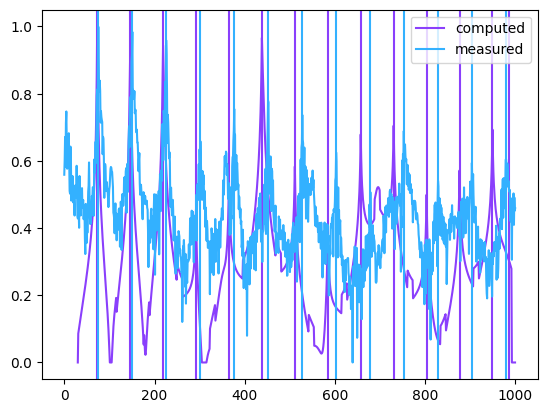

In [50]:
colors = ['#8a3ffc', '#33b1ff', '#007d79', '#ff7eb6', '#fa4d56', '#fff1f1', '#6fdc8c', '#4589ff', '#d12771', '#d2a106', '#08bdba', '#bae6ff', '#ba4e00', '#d4bbff']

geo = json.load(open(os.path.join(archive_path, didge["geometry"]), "r"))
geo = Geo(geo)
cadsd = geo.get_cadsd()

spektrum=cadsd.get_ground_spektrum()
ground_freq = np.array(list(spektrum.keys()))
ground_vols = np.array(list(spektrum.values()))
ground_vols -= ground_vols.min()
ground_vols /= ground_vols.max()
fft_maxima = get_harmonic_maxima(ground_freq, ground_vols)
for m in fft_maxima:
    plt.axvline(m, color=colors[0])

plt.plot(ground_freq, ground_vols, label="computed", color=colors[0])

sound_file = os.path.join(archive_path, didge["audio-samples"]["neutral-sound"])
freq, spectrum = do_fft(sound_file)
spectrum = np.log2(spectrum)
spectrum -= spectrum.min()
spectrum /= spectrum.max()

plt.plot(freq, spectrum, label="measured", color=colors[1])

fft_maxima = get_harmonic_maxima(freq, spectrum)
for m in fft_maxima:
    plt.axvline(m, color=colors[1])

plt.legend()
#print(fft_maxima)

In [49]:
notes=cadsd.get_notes()
notes["fft_maxima"] = fft_maxima[0:len(notes)]
notes.fft_maxima = notes.fft_maxima.round(2)
notes

,freq,impedance,rel_imp,note-number,cent-diff,note-name,fft_maxima
1686,72.7,3.185908e+07,1.000000,-31,16.971505,D1,74.97
155,185.0,7.729043e+06,0.242601,-15,-0.026096,F#2,150.86
265,295.0,5.042328e+06,0.158270,-7,-7.853717,D3,225.83
372,402.0,1.748191e+06,0.054873,-2,-43.630373,G3,301.71
482,512.0,2.287785e+06,0.071810,3,37.631656,C4,376.69
606,636.0,9.630371e+05,0.030228,6,-37.827890,D#4,451.66
698,728.0,8.437544e+05,0.026484,9,28.278088,F#4,527.54
820,850.0,8.842669e+05,0.027756,11,-39.951181,G#4,602.51
926,956.0,5.949348e+05,0.018674,13,-43.408513,A#5,678.40
